<a href="https://colab.research.google.com/github/nir6760/MScProjects/blob/main/GMDL_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GMDL , HW 4

**Nir Mualem 205467780**

**Or Cohen Tsemach 207498395**

In [ ]:
import torch
import torchvision
import numpy as np
import torch.utils.data
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import copy

In [ ]:
# another way to print our model outline + #parameters
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard
writer = SummaryWriter()

## Computer Exercise 1

In [ ]:
# a:
# Define transformations to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download and load the SVHN dataset
train_dataset = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform)
test_dataset = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform)

# b:
# Split the train dataset into train and validation sets
seed_num = 42
torch.manual_seed(seed_num)
train_part = 0.8
train_size = int(train_part * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset =  torch.utils.data.random_split(train_dataset, [train_size, val_size])

# c:
# Create data loaders
train_loader =  torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader =  torch.utils.data.DataLoader(val_dataset, batch_size=32,  shuffle=True, num_workers=2)
test_loader =  torch.utils.data.DataLoader(test_dataset, batch_size=32,  shuffle=True, num_workers=2)


dataloaders = {'train': train_loader,'val': val_loader, 'test': test_loader }
dataset_sizes = {'train': len(train_dataset),'val': len(val_dataset), 'test': len(test_dataset) }
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')


In [ ]:
# SVHN Dataset. Note: The SVHN dataset assigns the label 10 to the digit 0.
# However, in this Dataset, PyTorch assigns the label 0 to the digit 0 to be compatible with PyTorch loss functions which expect the class labels to be in the range [0, C-1]
nets_inputs_sizes_arr = train_dataset[0][0].shape
print(f'Image shape: {nets_inputs_sizes_arr}')
nets_inputs_sizes = nets_inputs_sizes_arr[0] * nets_inputs_sizes_arr[1] * nets_inputs_sizes_arr[2]
for set_name in ['train', 'val', 'test']:
  print(f'{set_name} samples: {dataset_sizes[set_name]}')
print(f'classes are:{classes}')

Image shape: torch.Size([3, 32, 32])
train samples: 58605
val samples: 14652
test samples: 26032
classes are:('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')


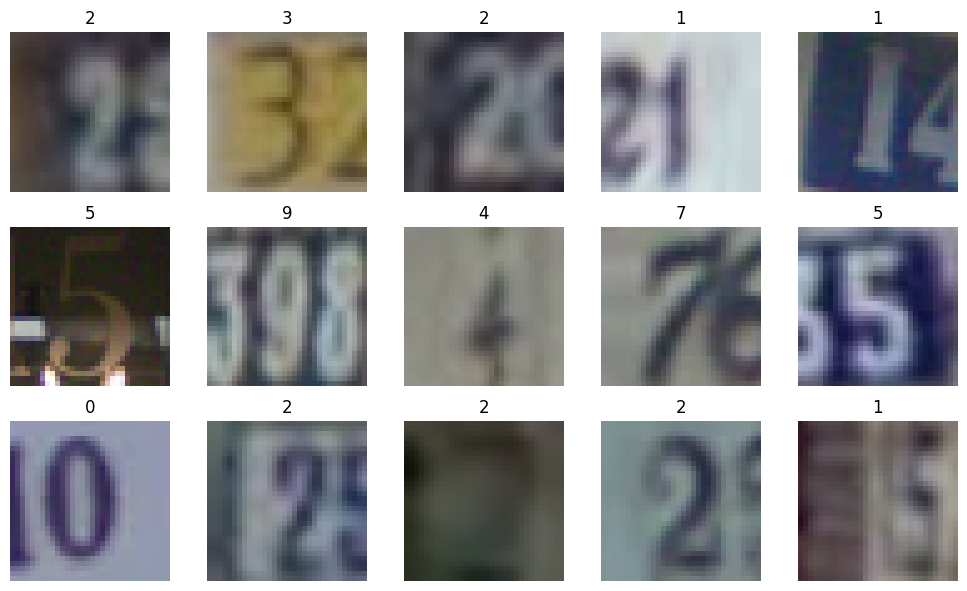

In [ ]:
# d:
# Visualize some images from the train dataset
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 6))

for i, ax in enumerate(axes.flat):
    image, label = train_dataset[i]
    image = image.permute(1, 2, 0)  # Reorder dimensions for matplotlib
    image = 0.5 * image + 0.5  # Unnormalize the image
    ax.imshow(image)
    ax.set_title(classes[label])
    ax.axis('off')

plt.tight_layout()
plt.show()

## Computer Exercise 2

In [ ]:
# FC sizes
input_size_fc = nets_inputs_sizes
hidden_sizes_fc = [128, 64]
output_size_fc = 10

# CNN sizes
input_size_cnn = nets_inputs_sizes
out_hidden_size_FCcnn = 64
output_size_cnn = 10
#conv
kernel_conv = 3
stride_conv = 1
padding_conv = 1
#conv1
in_channels_conv1 = 3
out_channels_conv1 = 10
#conv2
# in_channels_conv2 = out_channels_conv1
out_channels_conv2 = 20
#mp
kernel_mp = 2
stride_mp = 2
#padding_mp = 0 #default

In [ ]:
# Fully-connected neural network (FC)
class FCNet(nn.Module):
    def __init__(self, hidden_sizes_fc):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(input_size_cnn, hidden_sizes_fc[0])
        self.fc2 = nn.Linear(hidden_sizes_fc[0], hidden_sizes_fc[1])
        self.fc3 = nn.Linear(hidden_sizes_fc[1], output_size_cnn)

    def forward(self, x):
        x = torch.flatten(x, 1)#x.view(x.size(0), -1)  # Flatten the input tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
# Convolutional neural network (CNN)
class CNNNet(nn.Module):
    def __init__(self, kernel_conv):
        super(CNNNet, self).__init__()
        if kernel_conv == 1:
          in_hidden_size_FCcnn = 20 * 9 * 9
        elif kernel_conv == 10:
          in_hidden_size_FCcnn = 20 * 2 * 2
        else: # kernel size = 3
          in_hidden_size_FCcnn = 20 * 8 * 8
        self.conv1 = nn.Conv2d(in_channels_conv1, out_channels_conv1,
                               kernel_size=kernel_conv,
                               stride=stride_conv,
                               padding=padding_conv)
        self.pool1 = nn.MaxPool2d(kernel_size=kernel_mp, stride=stride_mp)
        self.conv2 = nn.Conv2d(out_channels_conv1, out_channels_conv2,
                               kernel_size=kernel_conv,
                               stride=stride_conv,
                               padding=padding_conv)
        self.pool2 = nn.MaxPool2d(kernel_size=kernel_mp, stride=stride_mp)
        self.fc1 = nn.Linear(in_hidden_size_FCcnn, out_hidden_size_FCcnn)
        self.fc2 = nn.Linear(out_hidden_size_FCcnn, output_size_cnn)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = torch.flatten(x, 1) # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Create instances of the FCNet and CNN
fcNet = FCNet(hidden_sizes_fc)
cnnNet = CNNNet(kernel_conv)

# Print the network architectures
print(fcNet)
print(cnnNet)

FCNet(
  (fc1): Linear(in_features=3072, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)
CNNNet(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1280, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


## Computer Exercise 3

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Runs on {device}')

# Define training parameters
lr_val = 0.001
num_epochs_val = 30

# Define loss function
criterion = nn.CrossEntropyLoss()

Runs on cuda


In [ ]:
def train_model(model, criterion, optimizer, dataloaders_dict, scheduler=None, num_epochs=3):
    since = time.time()
    model = model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    # softmax = nn.Softmax(dim=1)
    train_loss = []
    val_loss = []
    train_acc =[]
    val_acc = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders_dict[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # logits: The raw predictions from the last layer
                    logits = model(inputs)
                    _, preds = torch.max(logits, 1)
                    # using CE criterion, thus input is the logits
                    loss = criterion(logits, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if scheduler is not None and phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_acc = float(epoch_acc.detach().cpu().numpy())


            if phase == 'train':
              print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                  phase, epoch_loss, epoch_acc))
              train_loss.append(epoch_loss)
              train_acc.append(epoch_acc)
            elif phase == 'val':
              val_loss.append(epoch_loss)
              val_acc.append(epoch_acc)
              # deep copy the model the best accuracy based on the validation set
              if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    #print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, (train_loss, val_loss, train_acc, val_acc)

## Computer Exercises 3 and 4

In [ ]:
# fc
hidden_sizes_fc_lst = [[512, 256], [128,64],[64,32]]
# cnn
kernel_conv_lst = [10, 3, 1]

def changeHyperParamsExp(FCNet_flag=True):
  results_dict = {}
  if FCNet_flag:
    params_lst = hidden_sizes_fc_lst
    params_name_str = 'FC Hidden Sizes'
    Net = FCNet
  else:
    params_lst = kernel_conv_lst
    params_name_str = 'CNN Conv Kernels'
    Net = CNNNet
  exp_num = 0
  for params in params_lst:
    print(f'Experiment {exp_num}, {params_name_str} are :{params}')
    net =  Net(params)
    optimizer = optim.Adam(net.parameters(), lr=lr_val)
    results_dict[exp_num] = train_model(net, criterion, optimizer, dataloaders_dict=dataloaders, num_epochs=num_epochs_val)
    exp_num = exp_num + 1
    print()
  return results_dict

In [ ]:
# fc
fc_results_dict = changeHyperParamsExp(FCNet_flag=True)

In [ ]:
# cnn
cnn_results_dict = changeHyperParamsExp(FCNet_flag=False)

In [ ]:
# Function for plotting loss and accuracy, computer exercise 7
def plot_images(dict_lossacc, FCNet_flag=True, figsize=(15,10)):
  if FCNet_flag:
    params_lst = hidden_sizes_fc_lst
    params_name_str = 'FC Hidden Sizes'
    Net = FCNet
  else:
    params_lst = kernel_conv_lst
    params_name_str = 'CNN Conv Kernels'
    Net = CNNNet
  epochs = range(num_epochs_val)
  num_of_images_per_row = 2
  num_of_images_per_col = len(dict_lossacc)
  fig,axs=plt.subplots(num_of_images_per_col,num_of_images_per_row, figsize=figsize)
  # fig.suptitle("Computer Exercise 4:")
  plt.figure(dpi=80)
  iter = 0
  for key, value in dict_lossacc.items():
      tuple_lossacc = value[1]
      axs[iter, 0].set_title(f'Row {iter}, {params_name_str} are :{params_lst[iter]}')
      axs[iter, 0].plot(epochs, tuple_lossacc[0], label='Train', )
      axs[iter, 0].plot(epochs, tuple_lossacc[1], label='Validation')
      axs[iter, 0].set_xlabel('Epochs')
      axs[iter, 0].set_ylabel('Loss')
      axs[iter, 0].legend()


      axs[iter, 1].plot(epochs, tuple_lossacc[2], label='Train')
      axs[iter, 1].plot(epochs, tuple_lossacc[3], label='Validation')
      axs[iter, 1].set_xlabel('Epochs')
      axs[iter, 1].set_ylabel('Accuracy')
      axs[iter, 1].legend()


      iter= iter + 1
  fig.tight_layout()


  plt.show()

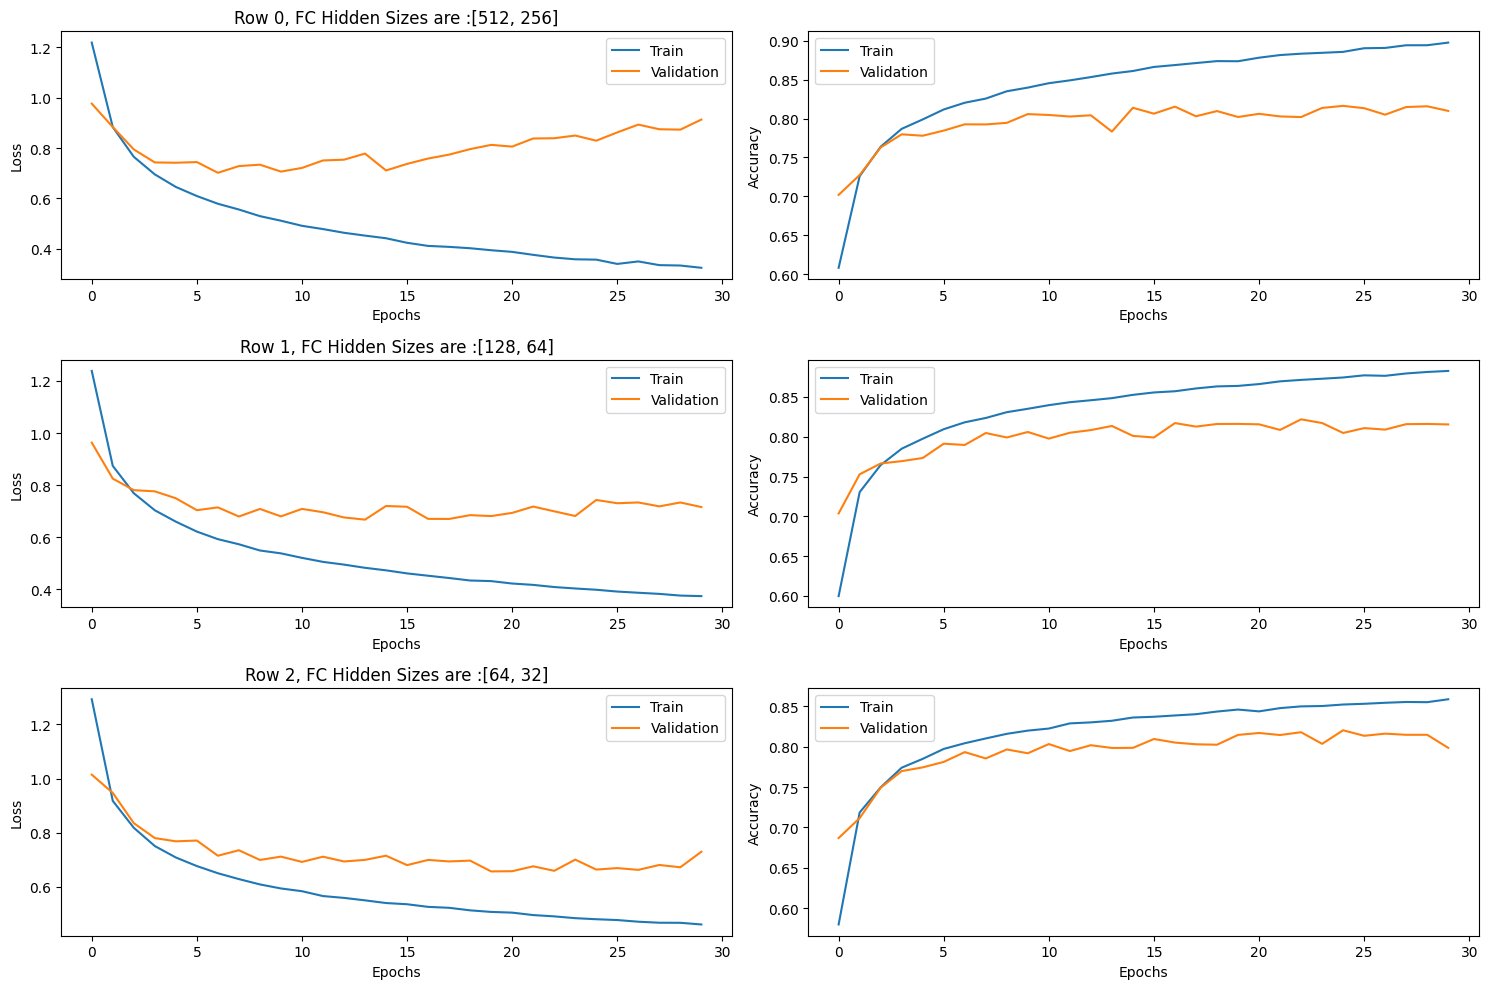

<Figure size 512x384 with 0 Axes>

In [ ]:
# fc
plot_images(fc_results_dict)

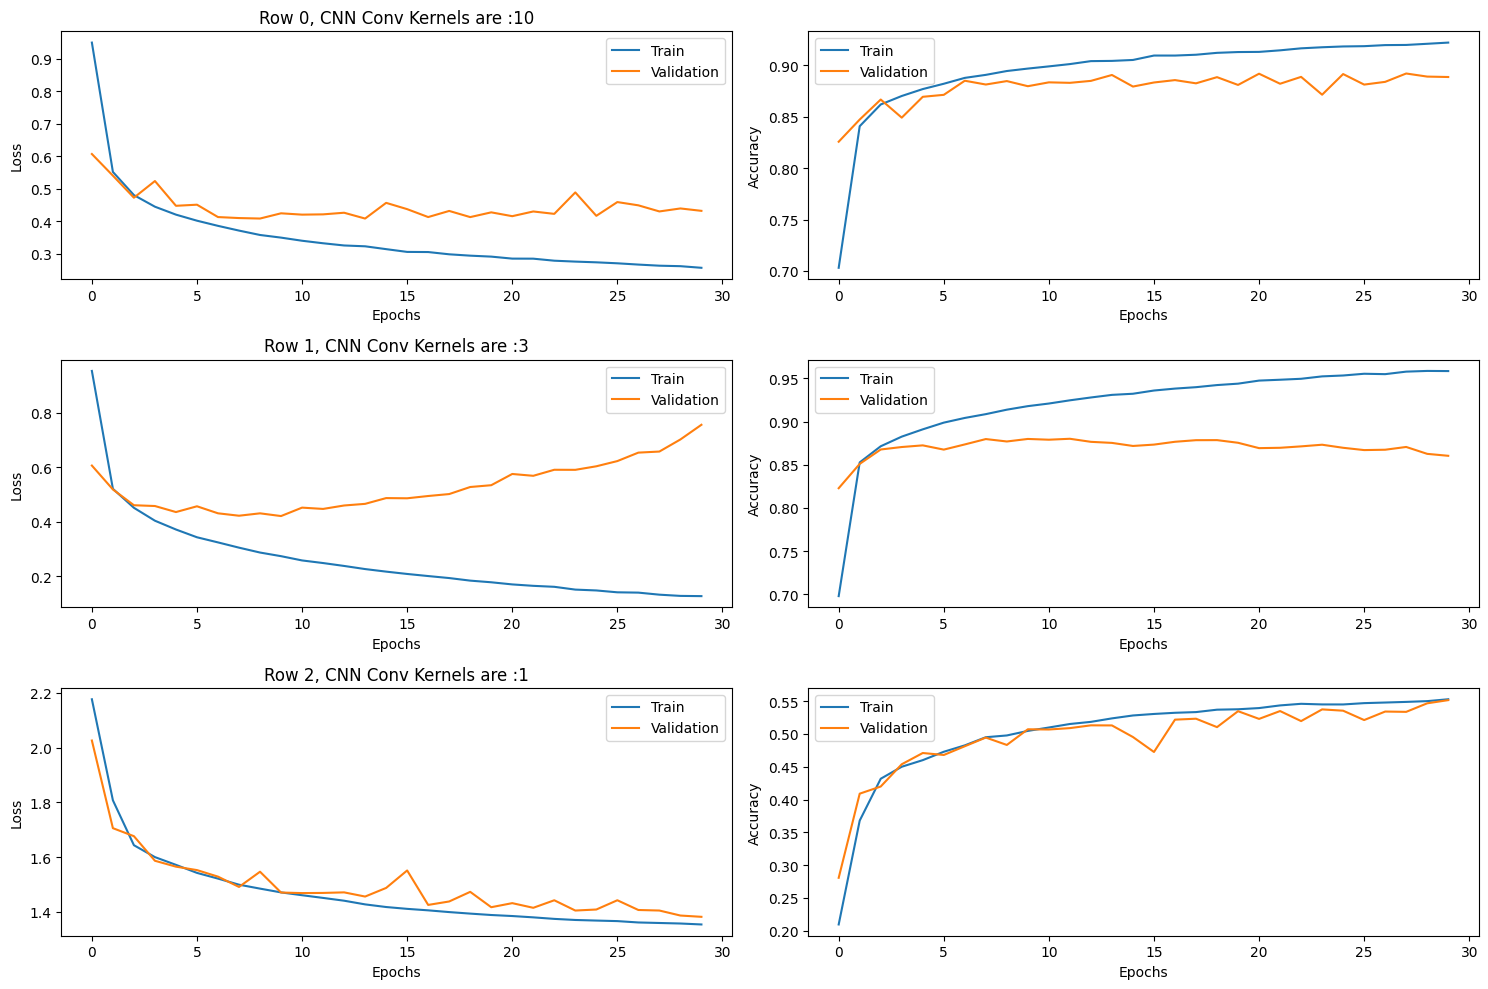

<Figure size 512x384 with 0 Axes>

In [ ]:
# cnn
plot_images(cnn_results_dict, FCNet_flag=False)

### Problem 1

The analysis revealed that the CNN architecture outperformed the FC architecture on the validation set (using conv kernels of 3 and 10). This conclusion was drawn based on comparative evaluations of the models' performance metrics.

Overfitting Assessment:
We examined the trends in the validation and training losses. It was observed that the validation loss increased while the training loss decreased at some point (after 10-15 epoch), indicating a potential case of overfitting.

Overfitting occurs when a model learns to fit the noise or specific patterns present in the training data, resulting in poor generalization to new, unseen data. In our case, the validation set is an unseen data during the training. The increasing validation loss suggests that the model's performance is deteriorating when faced with new examples, reinforcing the possibility of overfitting.

## Computer Exercise 5

In [ ]:
def findBestModel(results_dict, params_lst):
  best_acc = -1
  best_model = None
  for key, value in results_dict.items():
      model = value[0]
      val_acc_lst = value[1][3]
      model_acc = np.max(val_acc_lst)
      if model_acc >= best_acc:
          best_model = model
          best_acc = model_acc
  return best_model, best_acc, params_lst[key]

In [ ]:
round_num = 6
best_fc_model, best_fc_acc, best_fc_param = findBestModel(fc_results_dict, params_lst=hidden_sizes_fc_lst)
best_cnn_model, best_cnn_acc, best_cnn_param = findBestModel(cnn_results_dict, params_lst=kernel_conv_lst)
best_fc_acc = round(best_fc_acc, round_num)
best_cnn_acc = round(best_cnn_acc, round_num)
print(f'Best model (Only FCNet) on validition set -  accuracy {best_fc_acc}')
print(f'Best model (Only CNNnet) on validition set -  accuracy {best_cnn_acc}')
print()
best_model = None
if best_fc_acc > best_cnn_acc:
  best_model = best_fc_model
  best_param = best_fc_param
  print(f'Validation winner is ( with accuracy  of {best_fc_acc}):')
  print(best_fc_model)
else:
  best_model = best_cnn_model
  best_param = best_cnn_param
  print(f'Validation winner is ( with accuracy  of {best_cnn_acc}):')
  print(best_cnn_model)

Best model (Only FCNet) on validition set -  accuracy 0.821867
Best model (Only CNNnet) on validition set -  accuracy 0.892028

Validation winner is ( with accuracy  of 0.892028):
CNNNet(
  (conv1): Conv2d(3, 10, kernel_size=(10, 10), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(10, 10), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=80, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


In [ ]:
# another way to print our model outline + #parameters
from torchsummary import summary
input_shape = train_dataset[0][0].shape
summary(best_model, input_size=input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 25, 25]           3,010
         MaxPool2d-2           [-1, 10, 12, 12]               0
            Conv2d-3             [-1, 20, 5, 5]          20,020
         MaxPool2d-4             [-1, 20, 2, 2]               0
            Linear-5                   [-1, 64]           5,184
            Linear-6                   [-1, 10]             650
Total params: 28,864
Trainable params: 28,864
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.11
Estimated Total Size (MB): 0.19
----------------------------------------------------------------


In [ ]:
#computing the test accuracy for the model
def eval_model(model, val_loader):
  correct_count, all_count = 0, 0
  with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct_pred = torch.eq(labels, preds).cpu()
        correct_count += correct_pred.numpy().sum()
        all_count += len(labels)

  print("Number f Images Tested =", all_count)
  print("\nModel Accuracy =", (correct_count/all_count))

In [ ]:
eval_model(best_model, test_loader)

Number f Images Tested = 26032

Model Accuracy = 0.8770359557467732


### Problem 2


No, it is not guaranteed that the model chosen based on the validation set will give the best performance on the test set. The purpose of the validation set is to assess and compare different models or hyperparameter settings to select the one that performs well on unseen data. However, there is still a possibility that the chosen model may not generalize well to the test set.

When using the validation set to choose hyperparameter values, we make the basic assumption that the validation set is a representative sample of the overall data distribution. This assumption implies that the validation set shares similar characteristics with the test set. By evaluating the models on the validation set, we aim to estimate their performance on unseen data, including the test set.

The basic assumption underlying this approach is that if a model performs well on the validation set, it is likely to perform well on the test set as well. However, there is always a degree of uncertainty involved. The validation set serves as an approximation of the test set, and the performance of the chosen model on the test set can differ to some extent.

## Computer Exercise 6

In [ ]:
# pretrained Resnet excepts sizes of [3,224,224],
# This is the recommended transformation based on torch documentation (for pretrained Resnet)
transform_tl = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Download and load the SVHN dataset, using same seed to get the same batches
train_dataset_tl = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform_tl)
test_dataset_tl = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform_tl)
torch.manual_seed(seed_num) # same seed for the same batches
# Split the train dataset into train and validation sets
train_dataset_tl, val_dataset_tl =  torch.utils.data.random_split(train_dataset_tl, [train_size, val_size])
# Create data loaders
train_loader_tl =  torch.utils.data.DataLoader(train_dataset_tl, batch_size=32, shuffle=True, num_workers=2)
val_loader_tl =  torch.utils.data.DataLoader(val_dataset_tl, batch_size=32,  shuffle=True, num_workers=2)
test_loader_tl =  torch.utils.data.DataLoader(test_dataset_tl, batch_size=32,  shuffle=True, num_workers=2)

dataloaders_tl = {'train': train_loader_tl,'val': val_loader_tl, 'test': test_loader_tl }

nets_inputs_sizes_arr_tl = train_dataset_tl[0][0].shape
print(f'Image shape: {nets_inputs_sizes_arr_tl}')

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
Image shape: torch.Size([3, 224, 224])


#### Finetuning ResNet

In [ ]:
model_tl = models.resnet18(weights='ResNet18_Weights.DEFAULT')
# ResNet18_Weights.DEFAULT is equivalent to ResNet18_Weights.IMAGENET1K_V1 (Trained on ImageNet dataset).
num_ftrs = model_tl.fc.in_features

# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_tl.fc = nn.Linear(num_ftrs, len(classes))

model_tl = model_tl.to(device)
optimizer = optim.Adam(model_tl.parameters(), lr=lr_val)

In [ ]:
model_tl, loss_acc_tl = train_model(model_tl, criterion, optimizer, dataloaders_dict=dataloaders_tl, num_epochs=num_epochs_val)

In [ ]:
print(f'Validation: best loss is {np.min(loss_acc_tl[1])}, best accuracy is {np.max(loss_acc_tl[3])}')

Validation: best loss is 0.21712357779380534, best accuracy is 0.9466284466284467


### Problem 3

Finetuning ResNet is the chosen transfer learning method due to the assumption that the original training data of ResNet is significantly different from the SVHN dataset. The ResNet model used in this work was trained on ImageNet1K, which is a completely different dataset with a distinct classification task.

By fine-tuning the model, we enable it to adapt its learned representations to the SVHN dataset while still taking advantage of the architecture and the model's flexibility to optimize for the classification task. Additionally, we consider the specific characteristics and patterns present in the SVHN data. This approach has the potential to improve performance and extract meaningful features specific to the SVHN dataset, making it a suitable choice for the given task.

### Problem 4

The results indicate that the new network, fine-tuned ResNet, achieved superior performance compared to both the CNN and FC networks.

Our hypothesis is that this improvement can be attributed to several factors. By fine-tuning ResNet, the new network leverages the pre-trained features learned from a large-scale dataset like ImageNet, utilizing the powerful architecture known for its ability to handle complex visual tasks. These initial features capture general visual patterns, providing a strong starting point for the SVHN classification task. Fine-tuning allows the network to adapt these features to the specific characteristics and patterns present in the SVHN dataset, potentially resulting in enhanced performance compared to the CNN and FC networks.

 Additionally, fine-tuning enables the new network to adapt and generalize the learned representations to the SVHN dataset. By updating the weights during fine-tuning, the network learns task-specific features and optimizes the model parameters for a better fit with the SVHN data distribution.

### Problem 5 - LR Experiments

In [ ]:
lr_lst = [0.01, 0.0001, 0.00001, 0.000001]
def changeLRExp():
  results_dict = {}
  params_name_str = 'CNN LR'
  Net = CNNNet
  exp_num = 0
  for lr_val in lr_lst:
    print(f'Experiment {exp_num}, {params_name_str} is :{lr_val}')
    net =  Net(best_param)
    optimizer = optim.Adam(net.parameters(), lr=lr_val)
    results_dict[exp_num] = train_model(net, criterion, optimizer, dataloaders_dict=dataloaders, num_epochs=num_epochs_val)
    exp_num = exp_num + 1
    print()
  return results_dict

In [ ]:
lr_results_dict = changeLRExp()

In [ ]:
def findBestModelLoss(results_dict, params_lst):
  best_loss = 10000
  best_model = None
  model_acc = -1
  p = -1
  for key, value in results_dict.items():
      model = value[0]
      val_loss_lst = value[1][1]
      val_acc_lst = value[1][3]
      model_loss = np.min(val_loss_lst)
      if model_loss <= best_loss:
          best_model = model
          best_loss = model_loss
          p = key
  return best_model, best_loss, params_lst[p]

In [ ]:
_, best_lr_loss, best_lr = findBestModelLoss(lr_results_dict, params_lst=lr_lst)
print(f'Best model (LR Eexperiment) on validition set - lr: {best_lr}  Loss: {best_lr_loss}')

Best model (LR Eexperiment) on validition set - lr: 0.0001  Loss: 0.4175485071509775


In [ ]:
# Function for plotting loss and accuracy, computer exercise 7
def plot_imagesLRAcc(dict_lossacc, figsize=(15,10)):
  epochs = range(num_epochs_val)
  num_of_images_per_row = 2
  num_of_images_per_col = len(dict_lossacc)
  fig,axs=plt.subplots(num_of_images_per_col,num_of_images_per_row, figsize=figsize)
  # fig.suptitle("Computer Exercise 4:")
  plt.figure(dpi=80)
  iter = 0
  for key, value in dict_lossacc.items():
      tuple_lossacc = value[1]
      axs[iter,0].set_title(f'Row {iter}, LR is :{lr_lst[key]}')
      axs[iter,0].plot(epochs, tuple_lossacc[0], label='Train', )
      axs[iter,0].plot(epochs, tuple_lossacc[1], label='Validation')
      axs[iter,0].set_xlabel('Epochs')
      axs[iter,0].set_ylabel('Loss')
      axs[iter,0].legend()
      axs[iter, 1].plot(epochs, tuple_lossacc[2], label='Train')
      axs[iter, 1].plot(epochs, tuple_lossacc[3], label='Validation')
      axs[iter, 1].set_xlabel('Epochs')
      axs[iter, 1].set_ylabel('Accuracy')
      axs[iter, 1].legend()
      iter= iter + 1
  fig.tight_layout()
  plt.show()

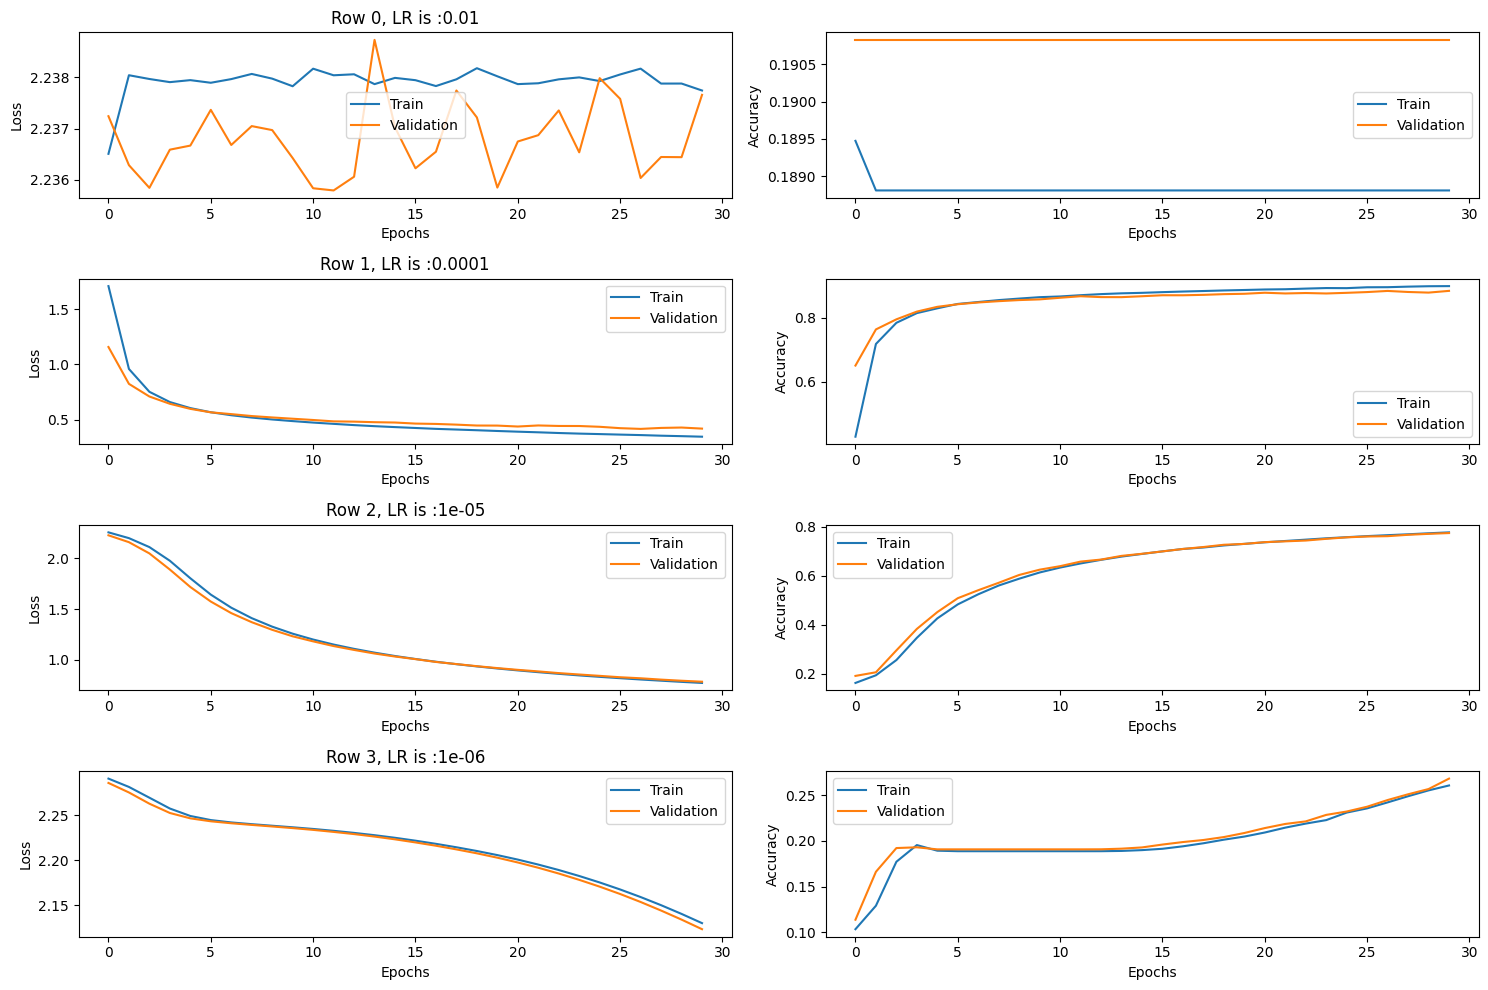

<Figure size 512x384 with 0 Axes>

In [ ]:
plot_imagesLRAcc(lr_results_dict)

Results explanations:

*   Learning Rate 0.01: Based on the loss and accuracy plots, it can be observed that the model fails to reach a satisfactory solution. This suggests that the learning rate is too high, causing the model to overshoot the optimal solution or make erratic updates. Consequently, the model struggles to converge to a better loss value and achieve higher accuracy.
*   Learning Rate 0.001 (computer exercise 4): In this case, the model successfully learns as evidenced by the convergence of the loss function and satisfactory accuracy values. This indicates that a learning rate of 0.001 strikes a balance between being small enough to ensure accuracy and large enough to facilitate effective learning. However, overfitting, as mentioned in problem 1, occurs.
*   Learning Rate 0.0001: The decreasing loss suggests that the model is learning. However, it seems that the optimal solution is not reached during training since the validation loss continues to decrease even after 30 epochs. This behavior suggests that the learning rate is too small.
*   Learning Rates 1e-6 and 1e-5: The minimal improvement in loss, along with low accuracy and high loss values, indicates that the model fails to effectively learn. This outcome suggests that the learning rates are excessively small, causing the model to take extremely tiny steps during parameter updates. In addition, it might even become stuck in a local (and potentially poor) minimum.


In conclusion, it seems that a learning rate of approximately 0.001 is the most suitable choice for the CNN model with a kernel size of 10 (at least within 30 epochs). This learning rate strikes a balance between ensuring accurate updates and facilitating effective learning. It allows for a steady convergence of the loss function while achieving satisfactory accuracy. Based on the experiment results, it may be suggested that further improvements could be achieved by using a learning rate scheduler.

# Exporting to PDF

In [ ]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
!jupyter nbconvert --to pdf ./drive/MyDrive/Colab_Notebooks/GMDL/GMDL_HW4.ipynb